In [1]:
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf
from tensorflow.keras import mixed_precision

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from sklearn.metrics import confusion_matrix

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(base_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.TrainSingleModelRam import TrainSingleModelRam
from Classes.DataProcessing.RamLoader import RamLoader
import json

import gc

import datetime
import re
from livelossplot import PlotLossesKeras
from GlobalUtils import GlobalUtils
from Classes.Modeling.CustomCallback import CustomCallback
from tensorflow.keras.callbacks import EarlyStopping
utils = GlobalUtils()

from tensorflow.keras.utils import GeneratorEnqueuer






import sys


helper = HelperFunctions()

tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy('mixed_float16')

1 Physical GPUs, 1 Logical GPUs

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6


In [2]:
load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.25,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)



2 2
Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping validation redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded explosion and earthquake dataset:
Evenly balanced among classes in the train set.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (20507, 0.4987)  |  explosion: (20616, 0.5013)  
Val ds:
earthquake: (255, 0.0762)  |  explosion: (3092, 0.9238)  
Test ds:
earthquake: (176, 0.0789)  |  explosion: (2055, 0.9211)  


In [3]:
is_lstm = True
num_channels = 3    

use_time_augmentor = True
scaler_name = "normalize"
use_noise_augmentor = True
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.075


shutdown = False

num_classes = len(list(set(loadData.label_dict.values())))



ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = False, 
                      meier_load = False)

x_train, y_train, x_val, y_val, noiseAug = ramLoader.load_to_ram()

Fitting noise set time augmentor: [--------------------------------------->] 100 %

Fit process completed after 9.521050214767456 seconds. Total datapoints fitted: 21199.
Average time per datapoint: 0.0004491273274573072


Fitting train time augmentor: [--------------------------------------->] 100 %

Fit process completed after 13.554574966430664 seconds. Total datapoints fitted: 41123.
Average time per datapoint: 0.0003296105577518825


Fitting validation time augmentor: [--------------------------------------->] 100 %

Fit process completed after 1.6006190776824951 seconds. Total datapoints fitted: 3347.
Average time per datapoint: 0.00047822500080146256


Stage one loading training set, timeAug: [--------------------------------------->] 100 %

Stage one loading validation set, timeAug: [--------------------------------------->] 100 %

Fit process of normalizer skipped as unecessary


Stage one loading noise set, timeAug: [--------------------------------------->] 100 %

Stage two 

['20210513-180642']
Trying to create result file
Made result file:  results_MLSTM_FCN_earthExplo_timeAug_normalize_noiseAug_earlyS_unbalanced_valtest_subsample-0.25_numChannels-3_f2.csv
[   {'model_type': 'MLSTM_FCN'},
    {   'batch_size': 256,
        'epochs': 50,
        'learning_rate': 0.0001,
        'meier_load': False,
        'optimizer': 'rmsprop',
        'output_layer_activation': 'sigmoid',
        'units': 64}]
Saving file. 17 rows.
results_MLSTM_FCN_earthExplo_timeAug_normalize_noiseAug_earlyS_unbalanced_valtest_subsample-0.25_numChannels-3_f2.csv saved to path:   /media/tord/T7/Thesis_ssd/MasterThesis3/GridSearchResults/2_classes
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6000, 3)]    0                                            
_________________________________

160/160 [==============================] - 33s 204ms/step - loss: 0.5237 - precision: 0.7309 - recall: 0.7874 - binary_accuracy: 0.7486 - val_loss: 0.3212 - val_precision: 0.2250 - val_recall: 0.1484 - val_binary_accuracy: 0.8978
- val_f2: 0.1613
Epoch 6/50
160/160 [==============================] - 33s 204ms/step - loss: 0.5068 - precision: 0.7422 - recall: 0.7974 - binary_accuracy: 0.7585 - val_loss: 0.3274 - val_precision: 0.2537 - val_recall: 0.4051 - val_binary_accuracy: 0.8648
- val_f2: 0.364
Epoch 7/50
160/160 [==============================] - 33s 204ms/step - loss: 0.4974 - precision: 0.7453 - recall: 0.7906 - binary_accuracy: 0.7618 - val_loss: 0.3096 - val_precision: 0.2495 - val_recall: 0.3620 - val_binary_accuracy: 0.8696
- val_f2: 0.3336
Epoch 8/50
160/160 [==============================] - 34s 211ms/step - loss: 0.4852 - precision: 0.7491 - recall: 0.7961 - binary_accuracy: 0.7680 - val_loss: 0.7134 - val_precision: 0.1501 - val_recall: 0.8219 - val_binary_accuracy: 0.63

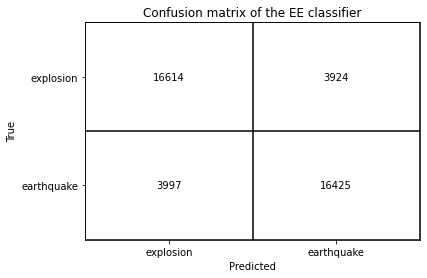

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[16614,  3924],
       [ 3997, 16425]], dtype=int32)>
              precision    recall  f1-score   support

   explosion       0.81      0.81      0.81     20538
  earthquake       0.81      0.80      0.81     20422

    accuracy                           0.81     40960
   macro avg       0.81      0.81      0.81     40960
weighted avg       0.81      0.81      0.81     40960

Unsaved val eval:
2350 724 66 188
['explosion', 'earthquake']
EE


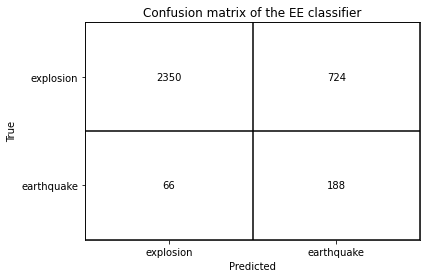

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2350,  724],
       [  66,  188]], dtype=int32)>
              precision    recall  f1-score   support

   explosion       0.97      0.76      0.86      3074
  earthquake       0.21      0.74      0.32       254

    accuracy                           0.76      3328
   macro avg       0.59      0.75      0.59      3328
weighted avg       0.91      0.76      0.82      3328



In [4]:
use_tensorboard = True
use_liveplots = False
use_custom_callback = True
use_early_stopping = True
start_from_scratch = False
use_reduced_lr = True
log_data = True
model_type = "MLSTM_FCN"

beta = 2

def clear_tensorboard_dir():
        import os
        import shutil
        path = f"{base_dir}/Tensorboard_dir/fit"
        files = os.listdir(path)
        print(files)
        for f in files:
            shutil.rmtree(os.path.join(path,f))
if use_tensorboard:
    clear_tensorboard_dir()


modelTrain = TrainSingleModelRam(noiseAug, helper,
                              loadData, model_type, num_channels, use_tensorboard, use_liveplots,
                              use_custom_callback, use_early_stopping, use_reduced_lr, ramLoader,
                              log_data = log_data, 
                              start_from_scratch = start_from_scratch, beta = beta)

params = {    
    "batch_size" : 256,
    "epochs" : 50,
    "learning_rate" : 0.0001,
    "optimizer" : "rmsprop",
    "units" : 64,
    "meier_load" : False,
    "output_layer_activation" : "sigmoid"
}
model = modelTrain.run(x_train, y_train, x_val, y_val, None, None, 16, 15, evaluate_train = True, evaluate_val = True, evaluate_test = False, meier_mode = False, **params)

2352 722 65 189


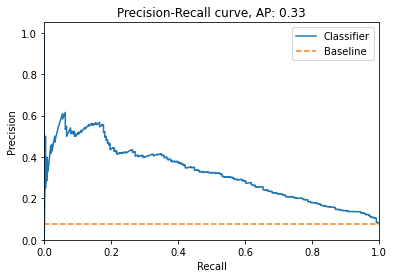

['explosion', 'earthquake']
EE


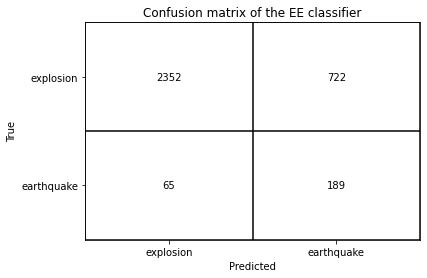

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2352,  722],
       [  65,  189]], dtype=int32)>
              precision    recall  f1-score   support

   explosion       0.97      0.77      0.86      3074
  earthquake       0.21      0.74      0.32       254

    accuracy                           0.76      3328
   macro avg       0.59      0.75      0.59      3328
weighted avg       0.91      0.76      0.82      3328



In [5]:
conf, report, accuracy, precision, recall, fscore = helper.evaluate_generator(model, x_val, y_val, params["batch_size"],
                                                                             loadData.label_dict, num_channels, noiseAug,
                                                                             scaler_name, 2, plot_conf_matrix = True, plot_p_r_curve = True, beta = beta)

In [6]:
accuracy, precision, recall, fscore

(0.76352163461538458, 0.20746400000000001, 0.74409400000000003, 0.4904)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6000, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 6000, 128)    3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 6000, 128)    512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 6000, 128)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
save_dir = '/media/tord/T7/Thesis_ssd/SavedModels/MLSTM-FCN'
model_name = 'MLSTM-FCN_EE_final'
model_path = f'{save_dir}/{model_name}'

model.save(model_path)
#model = helper.load_model(model_path)

INFO:tensorflow:Assets written to: /media/tord/T7/Thesis_ssd/SavedModels/InceptionTime/MLSTM-FCN_EE_final/assets


INFO:tensorflow:Assets written to: /media/tord/T7/Thesis_ssd/SavedModels/InceptionTime/MLSTM-FCN_EE_final/assets


In [9]:
def get_false_negative_indexes(rounded_predictions, y_test):
    false_negative_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 1 and rounded_predictions[i] == 0:
            false_negative_indexes.append(i)
    return false_negative_indexes

def get_false_positive_indexes(rounded_predictions, y_test):
    false_positive_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 0 and rounded_predictions[i] == 1:
            false_positive_indexes.append(i)
    return false_positive_indexes

def get_true_positive_indexes(rouneded_predictions, y_test):
    true_positive_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 1 and rounded_predictions[i] == 1:
            true_positive_indexes.append(i)
    return true_positive_indexes

def get_true_negative_indexes(rouneded_predictions, y_test):
    true_negative_indexes = []
    for i in range(len(rounded_predictions)):
        if y_test[i] == 0 and rounded_predictions[i] == 0:
            true_negative_indexes.append(i)
    return true_negative_indexes

predictions = helper.predict_RamGenerator(model, x_val, y_val, params["batch_size"], True, noiseAug, loadData.label_dict, 3)
rounded_predictions = np.rint(predictions)
y = y_val


false_negatives_indexes = get_false_negative_indexes(rounded_predictions, y)
false_positives_indexes = get_false_positive_indexes(rounded_predictions, y)
true_negative_indexes = get_true_negative_indexes(rounded_predictions, y)
true_positive_indexes = get_true_positive_indexes(rounded_predictions, y)

# True Positive

In [10]:
import pprint
i = 0
pp = pprint.PrettyPrinter(indent = 4)

Predicted label: [ 0.9459515], Correct: [1]
Transformed


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


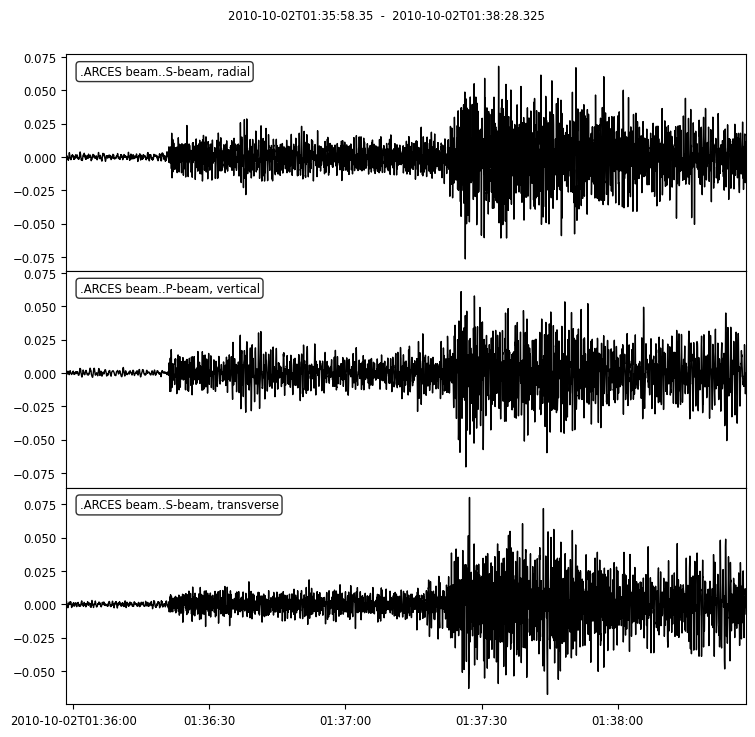

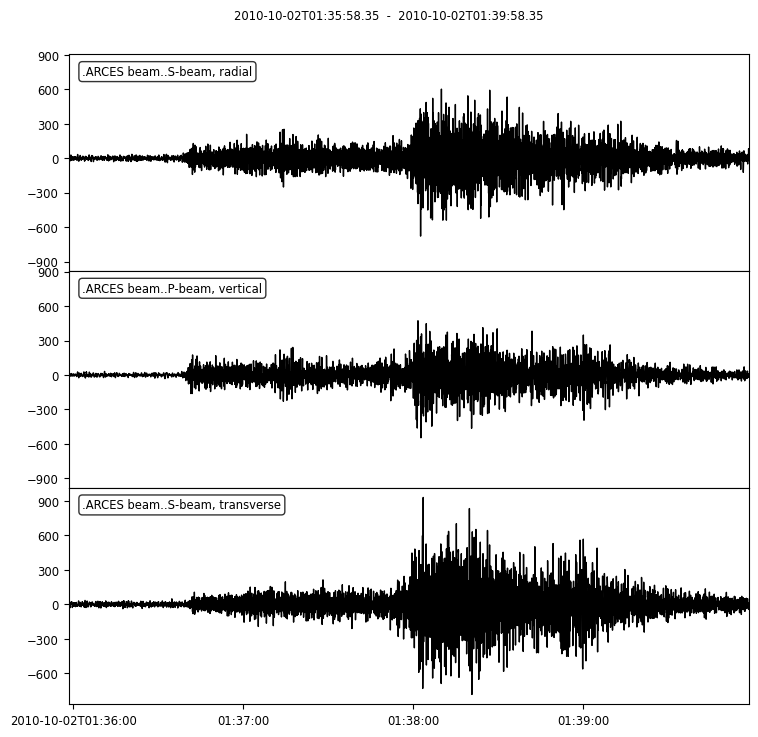

{   'analyst_pick_time': None,
    'az_to_arces': 162.11028823239158,
    'baz_to_arces': 348.5501326700314,
    'dist_to_arces': 853.5922704788013,
    'est_arrivaltime_arces': '2010-10-02 01:36:58.340000',
    'event_type': 'earthquake',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.0037043446963576122,
    'magnitude_sqrtdist_ratio': 0.10822725132739336,
    'magnitudes': [   {   'mag': 3.162,
                          'magnitude_type': 'Mb',
                          'origin_id': 'smi:local/0c393f40-54e0-47fe-8f78-b31635a00271',
                          'resource_id': 'smi:local/4c1f4342-fe33-455d-be3f-9cc09673ce18'},
                      {   'mag': 3.2,
                          'magnitude_type': 'Ml',
                          'origin_id': 'smi:local/0c393f40-54e0-47fe-8f78-b31635a00271',
                          'resource_id': 'smi:local/9e7afb3c-ba7e-4926-857f-0ee862501626'}],
    'origins': [   {   'arrivals': [   {   'azimuth': 289.90144,
             

In [11]:
index = true_positive_indexes[i]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
i += 1

# False Positive

In [12]:
j = 0

Predicted label: [ 0.88024974], Correct: [0]
Transformed
20


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


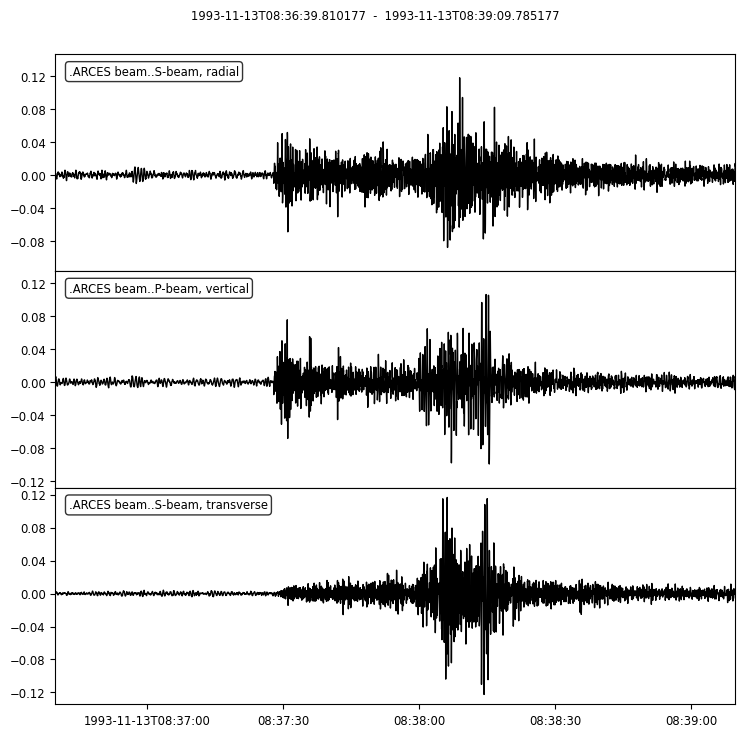

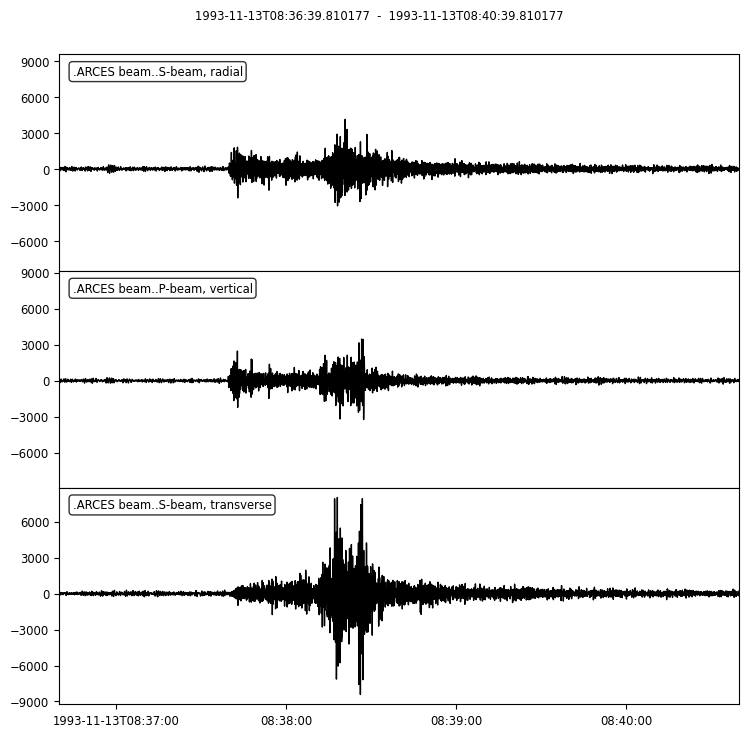

{   'analyst_pick_time': None,
    'az_to_arces': 319.7804682236783,
    'baz_to_arces': 135.19103507121378,
    'dist_to_arces': 297.8464745197724,
    'est_arrivaltime_arces': '1993-11-13 08:37:39.822000',
    'event_type': 'explosion',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.007050612243726902,
    'magnitude_sqrtdist_ratio': 0.12168108198001239,
    'magnitudes': [   {   'creation_info': {'agency_id': 'SDF'},
                          'mag': 2.1,
                          'magnitude_type': 'MC',
                          'origin_id': 'smi:local/dc88a9ce-340f-4b1c-9c50-0b6e3f2ca94d',
                          'resource_id': 'smi:local/19d611d1-01e1-4c2a-960a-0d8a63bc9161'}],
    'origins': [   {   'creation_info': {'agency_id': 'HEL'},
                       'depth': 0.0,
                       'latitude': 67.56,
                       'longitude': 30.44,
                       'resource_id': 'smi:local/dc88a9ce-340f-4b1c-9c50-0b6e3f2ca94d',
              

In [38]:
# Plotting false negative
index = false_positives_indexes[j]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
print(j)
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
j += 1

# True Negative

In [39]:
k = 0

Predicted label: [ 0.06588777], Correct: [0]
Transformed


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


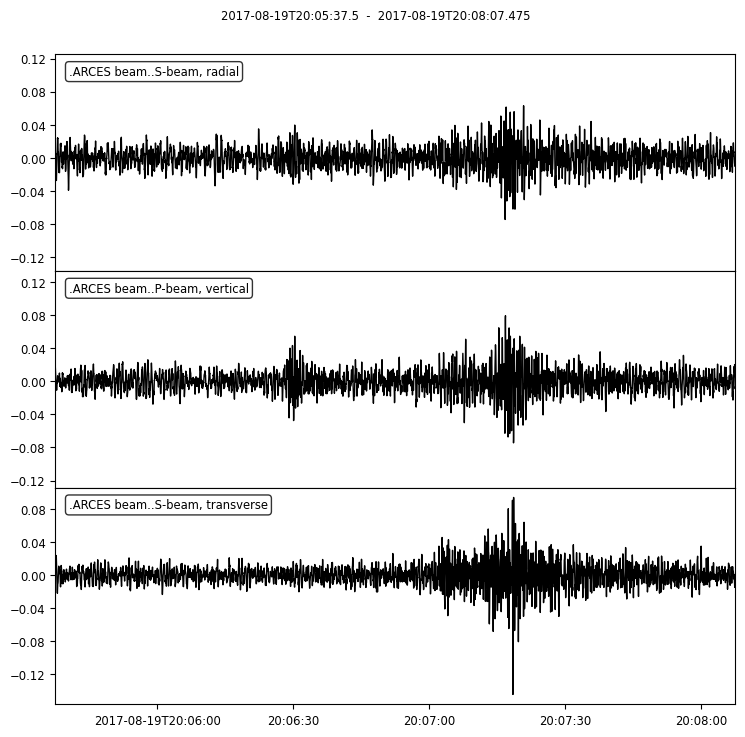

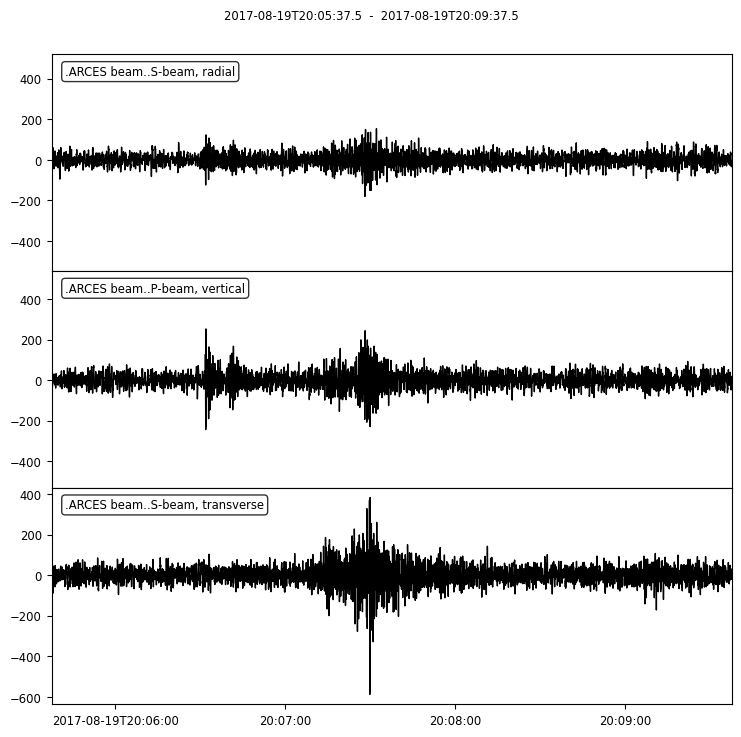

{   'analyst_pick_time': None,
    'az_to_arces': 306.01756761369984,
    'baz_to_arces': 118.24751218162167,
    'comments': [   {   'creation_info': {'author': 'general'},
                        'resource_id': 'smi:local/9525b865-d80a-431c-9583-3b978cde76f6',
                        'text': 'FULLY AUTOMATIC, EVENT TYPE & LOCATION & '
                                'MAGNITUDE UNCHECKED'},
                    {   'creation_info': {'author': 'auto-id'},
                        'resource_id': 'smi:local/b0f38e5e-ef7a-418e-ba02-dafadda22423',
                        'text': 'AUTO-ID  EQ/EX = -0.506166 0/2'},
                    {   'creation_info': {'author': 'mining area'},
                        'resource_id': 'smi:local/a6f23510-1b09-429a-a058-87bb92df4fe5',
                        'text': 'MINING AREA & TIME WINDOW: KIROVSK  9KM'}],
    'dist_to_arces': 401.6337211277944,
    'est_arrivaltime_arces': '2017-08-19 20:06:37.489000',
    'event_type': 'explosion',
    'event_type_certa

In [48]:
# Plotting true negative
index = true_negative_indexes[k]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
k += 1

# False Negative

In [49]:
m = 0

Predicted label: [ 0.32924125], Correct: [1]
Transformed
27


/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/tord/miniconda3/envs/thesis/lib/python3.8/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


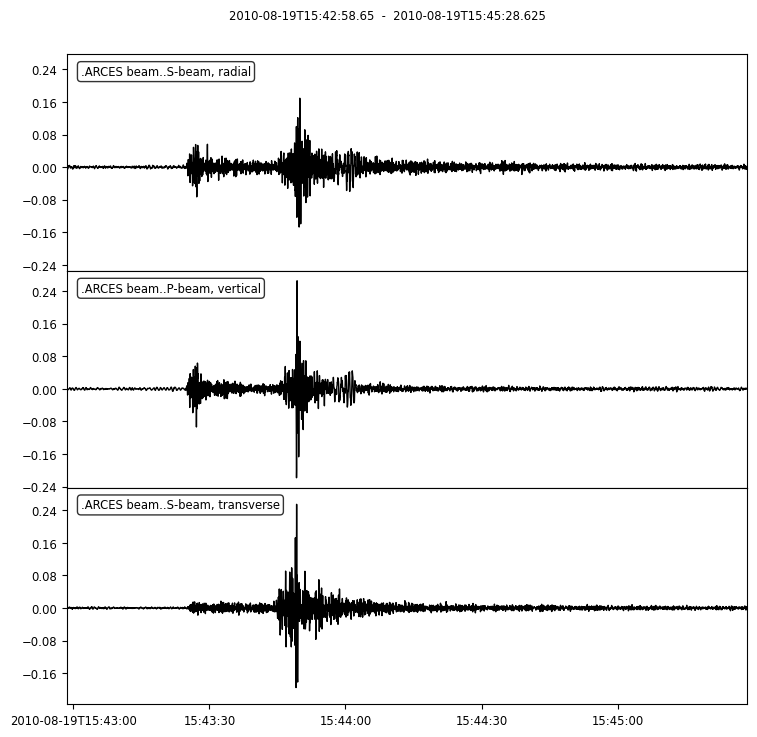

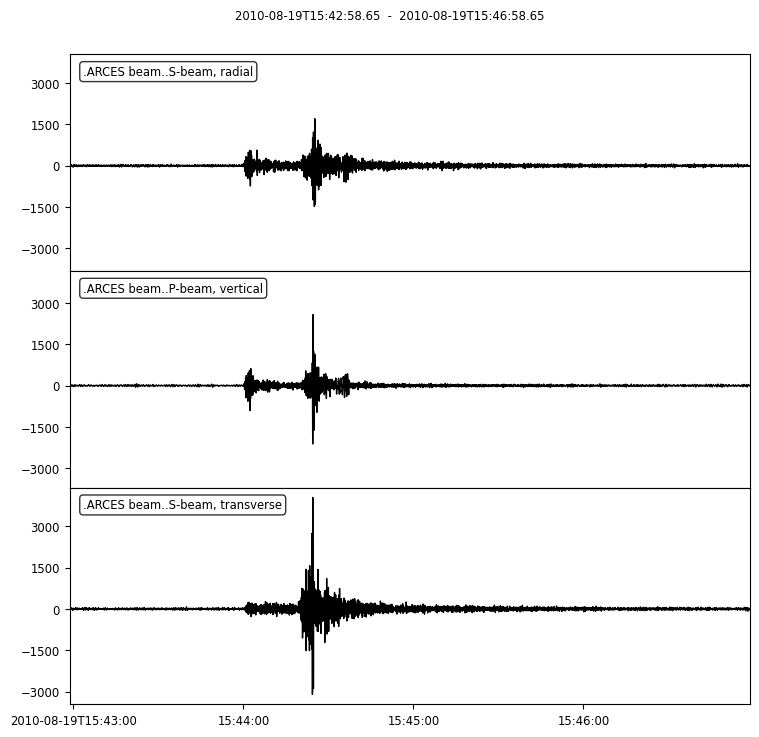

{   'analyst_pick_time': None,
    'az_to_arces': 278.5619690409509,
    'baz_to_arces': 94.6876364105253,
    'dist_to_arces': 163.24669230006452,
    'est_arrivaltime_arces': '2010-08-19 15:43:58.662000',
    'event_type': 'earthquake',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.013017109076207359,
    'magnitude_sqrtdist_ratio': 0.16631703697138378,
    'magnitudes': [   {   'mag': 2.125,
                          'magnitude_type': 'Mb',
                          'origin_id': 'smi:local/84252838-0beb-434b-bec9-c7d0f227749e',
                          'resource_id': 'smi:local/bb4a0034-65c6-4440-9162-da3aa64b1635'},
                      {   'mag': 1.85,
                          'magnitude_type': 'Ml',
                          'origin_id': 'smi:local/84252838-0beb-434b-bec9-c7d0f227749e',
                          'resource_id': 'smi:local/9e390d68-9de4-4d3d-8abd-c145aa438ae0'}],
    'origins': [   {   'arrivals': [   {   'azimuth': 94.871542,
              

In [77]:
# Plotting false negative
index = false_negatives_indexes[m]
original_trace, sample_info = handler.path_to_trace(val_ds[index][0])
transformed_trace = x_val[index]
print(f"Predicted label: {predictions[index]}, Correct: {y_val[index]}")
print("Transformed")
print(m)
helper.plot_event(transformed_trace, sample_info)
helper.plot_event(original_trace, sample_info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(sample_info)
m += 1